#### 201724500 심진섭 Machine Learning Assignment #1
## 1. Get dataset (Business & data understanding)

>가장 먼저, pdf에서 제공받은 홈페이지에서 dataset을 가져와 읽어온다.

나는 포르투갈에서 진행한 은행 캠페인의 고객 dataset을 받아왔다.  
Classfication에 적합한 data이며, 해당 dataset에서 각 열의 의미는 아래와 같다.  

- age : 고객의 나이
- job : 고객의 직업
- marital : 기혼 여부
- education : 교육 여부 (unknown, primary, secondary, teritary)
- default : 카드 요금 체납 여부
- balance : 연 평균 잔고 (유로 단위)
- housing : 주택 대출 여부
- loan : 개인 대출 여부
- contact : 연락 수신 유형 (unknown, telephone, cellular)
- day : 해당 달의 마지막 연락(contact) 일자
- month : 해당 연도의 마지막 연락(contact) 달
- duration : 마지막 contact 기간 (초 단위)
- campaign : 해당 campaign이 진행되는 동안, 고객에게 간 연락(contact)의 횟수
- pdays : 이전 campaign의 연락을 받은 뒤로 며칠이 지났는지?
  - -1은, 이전에 연락이 간 적이 없음을 의미한다.
- previous : 해당 campaign이 진행되기 전 고객에게 간 연락(contact)의 횟수
- poutcome : 이전 campaign에 대한 결과 (unknwon, other, failure, success)
- y : 위의 입력에 대한 결과 값이다.
  - 위의 입력에 대해 고객이 Term deposit(정기 예금)에 가입했는지 Classification 한다.

### 1-1. Why classification?
아래와 같은 이유로 Classification을 사용하게 되었다.
- 해당 데이터는 16개의 feature(variable)에 대해 yes / no가 결과로 도출되어 있는 data이다.
  - 새로운 입력 data가 주어진다면, 결과로 yes인지 no인지 분류하는 예측을 하게 될 것이다.
  - 그 말은 곧, Binary classification 방식으로 진행되어야 하는 data라는 의미이다.
- 강의 자료에 있는 Naive bayes를 사용할 수 있었는데 왜 Decision tree를 사용했는가?
  - 16개의 feature와 40000여개의 example에 대해 모두 확률 계산을 하기엔 오래 걸릴 것이라고 판단했다.
  - 또한 실제 Decision tree의 구성 과정이 궁금해서, Decision tree를 모델로 사용하게 되었다.

In [ ]:
import pandas as pd

col_names = ["age", "job", "marital", "education", "default", "balance", 
             "housing", "loan", "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

with open('/content/sample_data/bank-full.csv', 'r') as file: 
  bank_data = pd.read_csv(file, sep = ";")

bank_data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Data preparation
> Data를 알고리즘에 따라 학습시키기 이전에, 전처리가 필요하다.

- Categorical data
  - 수치적 계산을 해야하기 때문에, categorical data로는 학습할 수 없다.
  - 따라서 factorize 함수를 통해 명목 데이터를 모두 수치값으로 변경하도록 한다.
- Missing value
  - NaN 값이 dataframe에 존재한다면, 학습이 불가능하다.
  - 따라서 반드시 NaN 값을 확인 해주어야 하며, 처리를 해주어야 한다.
  - 아래와 같은 방법으로 처리가 가능하다.
    - dropna : 해당 행 혹은 열을 삭제한다.
    - fillna : 해당 값을 앞이나 뒤의 값과 동일하게 채운다.
    - interporlate : 보간법을 이용해서 해당 값을 채운다.

In [ ]:
## Categorical data를 Numeric data 변환한다.

bank_data['job'], _ = bank_data['job'].factorize()
bank_data['marital'], _ = bank_data['marital'].factorize()
bank_data['education'], _ = bank_data['education'].factorize()
bank_data['default'], _ = bank_data['default'].factorize()
bank_data['housing'], _ = bank_data['housing'].factorize()
bank_data['loan'], _ = bank_data['loan'].factorize()
bank_data['contact'], _ = bank_data['contact'].factorize()
bank_data['month'], _ = bank_data['month'].factorize()
bank_data['poutcome'], _ = bank_data['poutcome'].factorize()
bank_data['y'], _ = bank_data['y'].factorize()

bank_data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,0,0,0,0,2143,0,0,0,5,0,261,1,-1,0,0,0
1,44,1,1,1,0,29,0,0,0,5,0,151,1,-1,0,0,0
2,33,2,0,1,0,2,0,1,0,5,0,76,1,-1,0,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,92,1,-1,0,0,0
4,33,4,1,2,0,1,1,0,0,5,0,198,1,-1,0,0,0


In [ ]:
# 현재 Data에는 nan값이 없음을 알 수 있다.
print(bank_data.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


## 3. Data classification
이제 실제 Classification을 위한 학습과 예측을 진행한다.  
나는 DecisionTreeClassification을 사용했으며, 진행 순서는 아래와 같다.  
1. 가장 먼저 Train set과 Test set을 분리한다.
  - 이 과정에서 Validation이 진행되면 좋을 것이다.
  - k-fold cross validation을 하듯, 같은 크기로 자르되 우선 first fold로 예측을 해본다.
2. Train set으로 fit() 함수를 통해 학습을 진행한다.
3. 이후 predict() 함수를 통해 실제 Test set을 대상으로 예측을 진행한다.
4. sklear의 metrics 모듈을 통해 모델의 성능을 평가할 수 있다.
  - Accuracy : TP + TN / (TP + TN + FP + FN)
  - Recall : TP  / (TP + FN)
  - Precision : TP / (TP + FP)
  - F1 Score : 2 X (Recall X Precision) / (Recall + Precision)
    - 이는 Recall과 Precision의 조화평균이다.
    - Precision과 Recall이 모두 높아야 높아지는 값이다.
  - Confusion matrix : 실제 TP, TN, FP, FN의 값을 4분면으로 표현한다.

### 3-1. Why use that scoring method?
내가 이번 학습에 사용한 것은 __"Two class classification"__ 모델이다.  
해당 모델은 __두 개의 Class 밖에 없기에__ 결과에 대해 아래와 같은 4가지 평가가 가능하다.
- True Positive
- True Negative
- False Positive
- False Negative

위의 4가지 결과를 가지고 측정할 수 있는 성능의 지표(Metric)는 위에서 언급한대로 아래와 같다.
- Accuracy : TP + TN / (TP + TN + FP + FN)
- Recall : TP  / (TP + FN)
- Precision : TP / (TP + FP)

위의 지표들은 Two class classification 모델 평가에 적합한 성능 지표이기 때문에, 해당 scoring 방식을 사용하게 되었다.

### 3-2. Decision tree classification
Decision tree의 형태로 model을 만드는 분류 방식이다.  
해당 방식은 아래의 사진과 같이 진행됨을 볼 수 있다.  

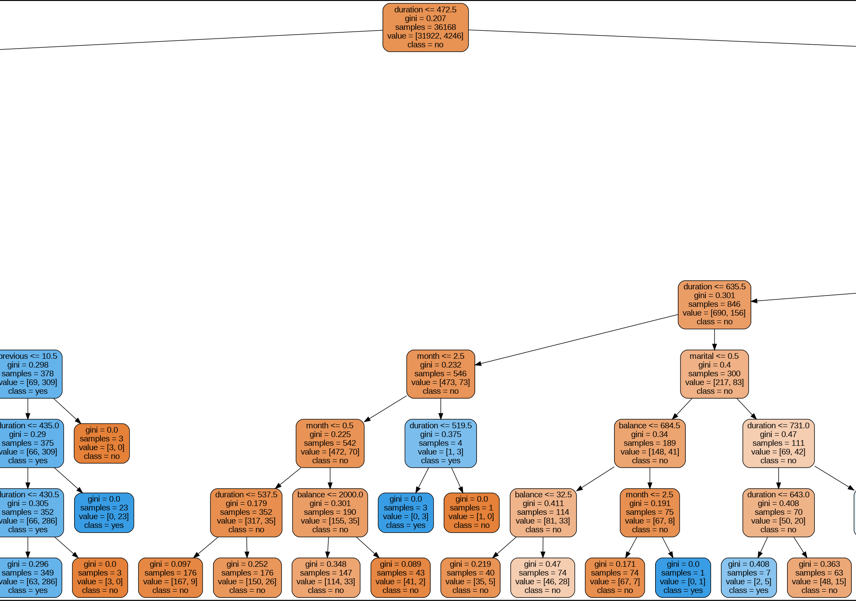

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.metrics as met
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from subprocess import check_call

clf = DecisionTreeClassifier(max_depth = 8)
train_data = bank_data[col_names[0:16]]
train_label = bank_data['y']

# 예측을 위해 Train set / Test set 분리
# 항상 같은 결과를 유지하기 위해 random_state 값을 부여하도록 한다.
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.2, random_state=156)

# Train data로 학습을 시킨 후, Test data로 예측
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

# 해당 Model의 평가를 위한 5가지 지표를 모두 출력해본다.
accuracy = met.accuracy_score(y_test, pred)
recall = met.recall_score(y_test, pred)
precision = met.precision_score(y_test, pred)
f1_score = met.f1_score(y_test, pred)
matrix = met.confusion_matrix(y_test, pred)

print('Accuracy: ', format(accuracy,'.2f'),'\n')
print('Recall: ', format(recall,'.2f'),'\n')
print('Precision: ', format(precision,'.2f'),'\n')
print('F1_score: ', format(f1_score,'.2f'),'\n')
print('Confusion Matrix:','\n', matrix)

# Decision tree를 가시화 시키기 위한 code
tree.export_graphviz(clf, 
               out_file = './tree_model.dot',
               class_names=['no', 'yes'],
               feature_names=col_names[0:16],
               impurity=True, filled=True,
               rounded=True)

check_call(['dot', '-Tpng', 'tree_model.dot', '-o', 'DecisionTree.png'])

Accuracy:  0.90 

Recall:  0.42 

Precision:  0.62 

F1_score:  0.50 

Confusion Matrix: 
 [[7729  271]
 [ 606  437]]


0

## 4. Cross validation
임의로 Test set 20%, Train set 80%로 자른 data set은 위와 같은 학습 결과를 보였다.  
하지만 임의로 자른 Test set이 최적의 set이라는 보장이 없다.  
따라서 우리는 k-fold cross validation을 통해 최적의 Test set을 찾아야 한다.  
k-fold cross validation은 아래와 같이 진행한다.
1. k값을 정한다. (보통은 5 혹은 10을 사용한다)
2. 정확히 k등분한 fold 중 하나를 Test set, 나머지를 Train set으로 잡는다.
3. 학습을 한 후 위와 같이 결과 점수를 매긴다.
  - Accuracy와 F1 Score가 모두 높은 Test set이 최적의 set이라고 할 수 있겠다.

In [ ]:
from sklearn.model_selection import KFold
# 5-fold cross validation으로 결정
clf = DecisionTreeClassifier()
k_fold = KFold(n_splits=5)
iter = 0

feature = bank_data[col_names[0:16]]
label = bank_data['y']

# 5개로 분리된 fold에 대해 cross validation 진행
for train_index, test_index in k_fold.split(feature):
    # k_fold split 함수는 index를 반환하기 때문에, 직접 data에서 참조를 해야함
    x_train, x_test = feature.iloc[train_index], feature.iloc[test_index]
    y_train, y_test = label[train_index], label[test_index]

    # 분리된 data에 대해서 학습 및 예측 진행 후, 점수 평가까지
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    iter += 1

    accuracy = met.accuracy_score(y_test, pred)
    recall = met.recall_score(y_test, pred)
    precision = met.precision_score(y_test, pred)
    f1_score = met.f1_score(y_test, pred)
    matrix = met.confusion_matrix(y_test, pred)

    train_size = x_train.shape[0]
    test_size = x_test.shape[0]

    print(iter, 'th fold test Accuracy : ', format(accuracy, '.3f'))
    print(iter, 'th fold test Recall : ', format(recall, '.3f'))
    print(iter, 'th fold test Precision : ', format(precision, '.3f'))
    print(iter, 'th fold test F1 Score : ', format(f1_score, '.3f'))
    print(iter, 'th fold Confusion matrix')
    print('\n', matrix, '\n')
    print(iter, 'th Test set index : ', test_index, '\n')
    print('Train set size : ', train_size, ',  Test set size : ', test_size, '\n')

1 th fold test Accuracy :  0.873
1 th fold test Recall :  0.454
1 th fold test Precision :  0.123
1 th fold test F1 Score :  0.194
1 th fold Confusion matrix

 [[7758  981]
 [ 166  138]] 

1 th Test set index :  [   0    1    2 ... 9040 9041 9042] 

Train set size :  36168 ,  Test set size :  9043 

2 th fold test Accuracy :  0.803
2 th fold test Recall :  0.500
2 th fold test Precision :  0.143
2 th fold test F1 Score :  0.222
2 th fold Confusion matrix

 [[7008 1526]
 [ 254  254]] 

2 th Test set index :  [ 9043  9044  9045 ... 18082 18083 18084] 

Train set size :  36169 ,  Test set size :  9042 

3 th fold test Accuracy :  0.736
3 th fold test Recall :  0.467
3 th fold test Precision :  0.110
3 th fold test F1 Score :  0.178
3 th fold Confusion matrix

 [[6392 2095]
 [ 296  259]] 

3 th Test set index :  [18085 18086 18087 ... 27124 27125 27126] 

Train set size :  36169 ,  Test set size :  9042 

4 th fold test Accuracy :  0.648
4 th fold test Recall :  0.564
4 th fold test Precis

## 5. Optimization
하지만 내가 생각하기엔, 위의 결과가 생각보다 만족스럽지 않다.  
Accuracy가 높으면 F1 score가 낮고, F1 score가 높으면 Accuracy가 높지 않다.  
과연 어떻게 성능을 더 최적화 시킬 수 있을까?  
  
내가 선택한 학습 방법은 Decision Tree를 통한 Classification 이었다.  
생각해보면 Decision Tree의 분기와 깊이에 따라서도 성능이 달라진다.  
- Decision Tree의 분기가 너무 많아지면 Overfitting되어 성능이 저하될 수 있다.
- Decision Tree의 depth가 너무 깊어지면, Overfitting되어 성능이 저하될 수도 있다.  
  
나는 그 중에서 depth를 너무 깊게 내려가지 않도록 max_depth 값을 조절했다.

In [ ]:
from sklearn.model_selection import KFold
# 5-fold cross validation 진행을 다시 하는데,
# Max depth를 8로 제한을 두어 너무 깊게 내려가지 않도록 한다.
clf = DecisionTreeClassifier(max_depth = 8)
k_fold = KFold(n_splits=5)
iter = 0

feature = bank_data[col_names[0:16]]
label = bank_data['y']

for train_index, test_index in k_fold.split(feature):
    x_train, x_test = feature.iloc[train_index], feature.iloc[test_index]
    y_train, y_test = label[train_index], label[test_index]

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    iter += 1

    accuracy = met.accuracy_score(y_test, pred)
    recall = met.recall_score(y_test, pred)
    precision = met.precision_score(y_test, pred)
    f1_score = met.f1_score(y_test, pred)
    matrix = met.confusion_matrix(y_test, pred)

    train_size = x_train.shape[0]
    test_size = x_test.shape[0]

    print(iter, 'th fold test Accuracy : ', format(accuracy, '.3f'))
    print(iter, 'th fold test Recall : ', format(recall, '.3f'))
    print(iter, 'th fold test Precision : ', format(precision, '.3f'))
    print(iter, 'th fold test F1 Score : ', format(f1_score, '.3f'))
    print(iter, 'th fold Confusion matrix')
    print('\n', matrix, '\n')
    print(iter, 'th Test set index : ', test_index, '\n')
    print('Train set size : ', train_size, ',  Test set size : ', test_size, '\n')

1 th fold test Accuracy :  0.944
1 th fold test Recall :  0.727
1 th fold test Precision :  0.345
1 th fold test F1 Score :  0.468
1 th fold Confusion matrix

 [[8320  419]
 [  83  221]] 

1 th Test set index :  [   0    1    2 ... 9040 9041 9042] 

Train set size :  36168 ,  Test set size :  9043 

2 th fold test Accuracy :  0.932
2 th fold test Recall :  0.506
2 th fold test Precision :  0.413
2 th fold test F1 Score :  0.454
2 th fold Confusion matrix

 [[8168  366]
 [ 251  257]] 

2 th Test set index :  [ 9043  9044  9045 ... 18082 18083 18084] 

Train set size :  36169 ,  Test set size :  9042 

3 th fold test Accuracy :  0.920
3 th fold test Recall :  0.431
3 th fold test Precision :  0.372
3 th fold test F1 Score :  0.399
3 th fold Confusion matrix

 [[8083  404]
 [ 316  239]] 

3 th Test set index :  [18085 18086 18087 ... 27124 27125 27126] 

Train set size :  36169 ,  Test set size :  9042 

4 th fold test Accuracy :  0.770
4 th fold test Recall :  0.555
4 th fold test Precis

확실히 향상된 성능을 볼 수 있다.  

하지만 depth를 너무 얕게 설정을 하면, 학습 결과에 신뢰도가 떨어지게 될 것이다.  
Depth는 Hyperparameter이기 때문에, validation을 통해 적정값을 찾아야 할 것 같다.  